In [1]:
import logging
from statistics import mean

import pandas as pd
import numpy as np  # TODO: change isnan to math.isnan
from pyomo.environ import *
from pyomo.util import infeasible
import openpyxl

from analysis import restore_plots
from model_utils.configuration import DATA as data_handler
from model_utils import data_handler as cnf_tools
from gen_utils import k_clustering

import matplotlib.pyplot as plt

import gurobi

logging.basicConfig(filename='example.log', encoding='utf-8', level=logging.INFO)

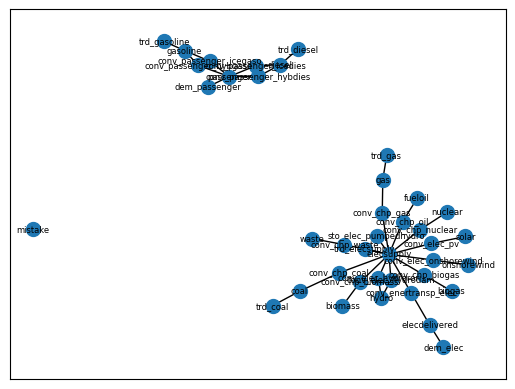

In [2]:
# Show network complexity if there is a connection issue
in_df = data_handler.fxe["FiE"].copy()
out_df = data_handler.fxe["FoE"].copy()
in_df["mistake"] = np.nan
out_df["mistake"] = np.nan
restore_plots.plot_io_network(in_df, out_df)

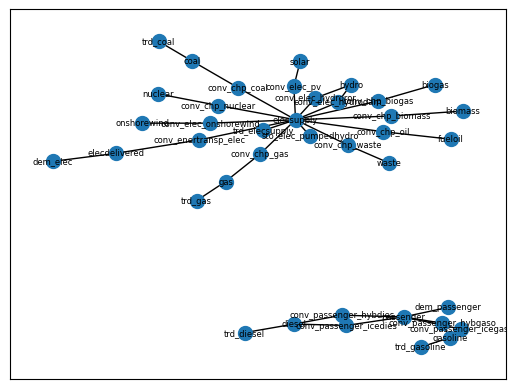

In [3]:
# Show network complexity
in_df = data_handler.fxe["FiE"]
out_df = data_handler.fxe["FoE"]
restore_plots.plot_io_network(in_df, out_df)

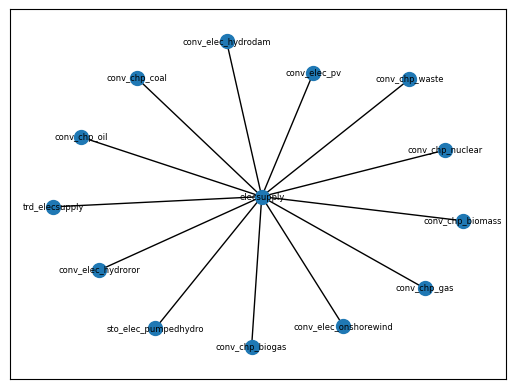

In [4]:
# Show network complexity of regular D-EXPANSE
dxp_tech = ["conv_chp_biogas","conv_chp_biomass","conv_chp_gas","conv_chp_oil","conv_chp_waste",
            "conv_chp_coal","conv_elec_hydrodam","conv_elec_hydroror","conv_chp_nuclear",
            "conv_elec_onshorewind","conv_elec_pv","sto_elec_pumpedhydro", "trd_elecsupply"]
dxp_flow = ["elecsupply"]

dxp_in_df = data_handler.fxe["FiE"].loc[dxp_tech, dxp_flow]
dxp_out_df = data_handler.fxe["FoE"].loc[dxp_tech, dxp_flow]
restore_plots.plot_io_network(dxp_in_df, dxp_out_df)

In [5]:
# Configuration
n_days = 1

In [6]:
# Create model sets
# Temporal
years = list(range(1990, 2020))
hours = list(range(n_days*24))  # NOTE: consider separating into day sets and hour sets

element_ids = pd.merge(in_df, out_df, how='outer', left_index=True, right_index=True).index

# Processes
conversions = set(element_ids[element_ids.str.startswith("conv_")])
extractions = set(element_ids[element_ids.str.startswith("ext_")])
trades = set(element_ids[element_ids.str.startswith("trd_")])
storages = set(element_ids[element_ids.str.startswith("sto_")])
processes = conversions | extractions | trades | storages

# Demands
demands = set(element_ids[element_ids.str.startswith("dem_")])

elements = set(element_ids)

# Flows
flows = set(pd.merge(in_df, out_df, how='inner').columns)

# Combinations
fout_e = cnf_tools.get_flow_element_dict(out_df.loc[~out_df.index.isin(demands)])
fin_e = cnf_tools.get_flow_element_dict(in_df.loc[~in_df.index.isin(extractions)])
f_e = cnf_tools.merge_dicts(fout_e, fin_e)

e_fout = cnf_tools.get_flow_element_dict(out_df.loc[~out_df.index.isin(demands)], by_element=True)
e_fin = cnf_tools.get_flow_element_dict(in_df.loc[~in_df.index.isin(extractions)], by_element=True)
e_f = cnf_tools.merge_dicts(e_fout, e_fin)

In [7]:
# Sets for special cases
chp_conversions = {i for i in conversions if "_chp_" in i}  # distinct capacity characteristics
vre_conversions = set(c for c in conversions for vre in ["onshorewind", "pv", "offshorewind"] if vre in c)

# Sets

In [8]:
# Initialise model
model = ConcreteModel()

# Indices 1xN
model.Years = Set(initialize=years, ordered=True)
model.Y0 = Set(initialize=[years[0]], ordered=True)
model.Hours = Set(initialize=hours, ordered=True)
model.H0 = Set(initialize=[hours[0]], ordered=True)

model.Convs = Set(initialize=conversions, ordered=False)
model.Extrs = Set(initialize=extractions, ordered=False)
model.Trades = Set(initialize=trades, ordered=False)
model.Stors = Set(initialize=storages, ordered=False)

model.Dems = Set(initialize=demands, ordered=False)

model.Pros = Set(initialize=processes, ordered=False)

model.Elems = Set(initialize=elements, ordered=False)
model.Flows = Set(initialize=flows, ordered=False)

# Special cases
# model.ProsGeneric = Set(initialize=processes-chp_conversions, ordered=False)
model.ConvsVRE = Set(initialize=vre_conversions, ordered=False)
model.ProsCap = Set(initialize=data_handler.build_cnf_set(processes, "enable_capacity"), ordered=False)
model.TradesImp = Set(initialize=data_handler.build_cnf_set(trades, "enable_import"), ordered=False)
model.TradesExp = Set(initialize=data_handler.build_cnf_set(trades, "enable_export"), ordered=False)

In [9]:
# Cartesian subsets
# See https://github.com/brentertainer/pyomo-tutorials/blob/master/intermediate/05-indexed-sets.ipynb
# Indices FxE with all
model.FiE = Set(within=model.Flows*model.Elems, ordered=False, 
                  initialize={(f, p) for f in flows for p in fin_e[f]})
model.FoE = Set(within=model.Flows*model.Elems, ordered=False, 
                   initialize={(f, p) for f in flows for p in fout_e[f]})
model.FxE = Set(within=model.Flows*model.Elems, ordered=False,
                initialize={(f, p) for f in flows for p in f_e[f]})

# Special cases
model.FoEchp = Set(within=model.Flows*model.Elems, ordered=False, 
                   initialize={(f, p) for f in flows for p in fout_e[f] if p in chp_conversions})
model.FoEgeneric = Set(within=model.Flows*model.Elems, ordered=False, 
                       initialize={(f, p) for f in flows for p in fout_e[f] if p not in chp_conversions})

# Parameters

In [10]:
model.NDAYS = Param(initialize=n_days, doc="Number of representative days")
model.TPERIOD = Param(initialize=365/n_days, doc="Adjust from representative days to year")

def p_discount_rates(mod, year):
    df = data_handler.get_const("country", "discount_factor")
    return 1 / np.power(1 + df, (year - mod.Years.first()))
model.DR = Param(model.Years, initialize=p_discount_rates, doc="Discount Factors")

# Variables

In [11]:
# Capacity TODO: find a way of eliminating unnecessary capacity variables
model.ctot = Var(model.ProsCap, model.Years, domain=NonNegativeReals, initialize=0)
model.cnew = Var(model.ProsCap, model.Years, domain=NonNegativeReals, initialize=0)
model.cret = Var(model.ProsCap, model.Years, domain=NonNegativeReals, initialize=0)

# Process activity
model.a = Var(model.Pros-model.Trades | model.Dems, model.Years, model.Hours, domain=NonNegativeReals, initialize=0)
model.aimp = Var(model.TradesImp, model.Years, model.Hours, domain=NonNegativeReals, initialize=0)
model.aexp = Var(model.TradesExp, model.Years, model.Hours, domain=NonNegativeReals, initialize=0)

# Demands
# model.dem = Var(model.Dems, model.Years, model.Hours, domain=NonNegativeReals, initialize=0)

# Flows
model.fin = Var(model.FiE, model.Years, model.Hours, domain=NonNegativeReals, initialize=0)
model.fout = Var(model.FoE, model.Years, model.Hours, domain=NonNegativeReals, initialize=0)


# Constraints
## In-out flow

Input - Output balance

In [12]:
def c_inoutbalance(model, flow, year, hour):
    f_out_of_prev_e = sum(model.fout[f, e, year, hour] for (f, e) in model.FoE if f == flow)
    f_into_next_e = sum(model.fin[f, e, year, hour] for (f, e) in model.FiE if f == flow)
    return  f_out_of_prev_e == f_into_next_e

model.c_inoutbalance = Constraint(model.Flows, model.Years-model.Y0, model.Hours, rule=c_inoutbalance)

In flow efficiency

In [13]:
# NOTE: it is likely that you will need to add a conversion factor and output ratio here!

def c_flowin(model, process, year, hour):    
    if process in model.Trades:
        if process in model.TradesExp:
            x = model.aexp[process, year, hour]
        else:
            return Constraint.Skip
    else:
        x = model.a[process, year, hour]
    x = x == sum(model.fin[f,p,year, hour] * data_handler.get_const_fxe(p, "input_efficiency", f) 
                 for (f, p) in model.FiE if p == process)
    return x

model.c_flowin = Constraint(model.Convs | model.Stors | model.Trades | model.Dems, model.Years-model.Y0, model.Hours, rule=c_flowin)

Out flow efficiency

In [14]:
# def c_flowout(mod, flow, element, year, hour):
#     if element in mod.Trades:
#         if element in mod.TradesImp:
#             act = mod.aimp[element, year, hour]
#         else:
#             return Constraint.Skip
#     else:
#         act = mod.a[element, year, hour]
#     output_eff = data_handler.get_const_fxe(element, "output_efficiency", flow)
#     return mod.fout[flow, element,year, hour] == output_eff * act

# model.c_flowout = Constraint(model.FoE, model.Years-model.Y0, model.Hours, rule=c_flowout)

def c_flow_out(model, element, y, h):
    """Balance element outflows to its activity."""
    if element in model.Trades:
        if element in model.TradesImp:
            act = model.aimp[element, y, h]
        else:
            return Constraint.Skip
    else:
        act = model.a[element, y, h]
    
    
    return act == sum(
        model.fout[f, e, y, h] / data_handler.get_const_fxe(e, "output_efficiency", f)
        for (f, e) in model.FoE
        if e == element
    )
    
model.c_flow_out = Constraint(model.Extrs | model.Convs | model.Stors | model.Trades, model.Years-model.Y0, model.Hours, rule=c_flow_out)

In [15]:
# Special case for CHP
def c_flowoutchp(mod, flow, element, year, hour):
    coeff = data_handler.get_const_fxe(element, "output_efficiency", flow)
    match flow:
        case "elecsupply":
            return coeff*mod.a[element, year, hour] == mod.fout[flow, element, year, hour]
        case "heatchp":
            # Allow heat curtailing
            return coeff*mod.a[element, year, hour] >= mod.fout[flow, element, year, hour]
        case other:
            raise KeyError("Invalid output flow  in 'model.FoEchp' builder:", flow)

model.c_flowoutchp = Constraint(model.FoEchp, model.Years, model.Hours, rule=c_flowoutchp)

Inflow / Outflow maximum share

In [16]:
def c_maxexportshare(model, flow, process, year, hour):
    if process in model.TradesExp:
        # Only exports supported, for now
        if data_handler.check_cnf(process, "enable_max_export_share"):
            max_share = data_handler.get_const(process, "flow_in_max_share")
            if max_share is not None:
                return model.fin[flow, process, year, hour] <= max_share * sum(model.fin[f, e, year, hour] for (f,e) in model.FiE if f == flow)
            raise ValueError("Max export share enabled without value for", process)
            
    return Constraint.Skip

model.c_maxexportshare = Constraint(model.FiE, model.Years, model.Hours, rule=c_maxexportshare)

In [17]:
def c_maximportshare(model, flow, process, year, hour):
    if process in model.TradesImp:
        # Only exports supported, for now
        if data_handler.check_cnf(process, "enable_max_import_share"):
            max_share = data_handler.get_const(process, "flow_out_max_share")
            if max_share is not None:
                return model.fout[flow, process, year, hour] <= max_share * sum(model.fout[f, e, year, hour] for (f,e) in model.FoE if f == flow)
            raise ValueError("Max import share enabled without value for", process)
        
    return Constraint.Skip

model.c_maximportshare = Constraint(model.FoE, model.Years, model.Hours, rule=c_maximportshare)

## Capacity

Maximum capacity constraint

$$\forall{p \in P, y \in Y} \quad ctot_{p, y} ≤ \text{max\_capacity\_annual}$$

In [18]:
def c_maxcapacityannual(mod, process, year):
    if process in model.ProsCap:
        cap_max = data_handler.get_const(process, "max_capacity_annual")
        return mod.ctot[process, year] <= cap_max if cap_max is not None else Constraint.Skip
    raise ValueError("Process", process, "has no capacity enabled.")

model.c_maxcapacityannual = Constraint(model.ProsCap, model.Years, rule=c_maxcapacityannual)

Capacity transfer
$$\forall{p \in P, y \in Y \setminus Y_{0}} \quad ctot_{p,y} = ctot_{p,y-1} + cnew_{p,y} - cret_{p,y}$$

In [19]:
def c_capacitytransfer(mod, process, year):
    if process not in mod.ProsCap:
        raise ValueError("Process", process, "has no capacity enabled.")
    total_capacity = mod.ctot[process, year-1] + mod.cnew[process, year] - mod.cret[process, year]
    return mod.ctot[process, year] == total_capacity
    
model.c_capacitytransfer = Constraint(model.ProsCap, model.Years-model.Y0, rule=c_capacitytransfer)

Capacity retirement

In [20]:
def c_capacityretirement(mod, process, year):
    if process not in model.ProsCap:
        raise ValueError("Process", process, "has no capacity enabled.")
    life = data_handler.get_const(process, "lifetime")
    if life is not None:
        cnf_retired = data_handler.get_annual(process, "initial_retired_capacity", year)
        if life <= year - mod.Years.first():
            return mod.cret[process, year] == cnf_retired + mod.cnew[process, year - life]
        return mod.cret[process, year] == cnf_retired
    return mod.cret[process, year] == 0  # Instalments last indefinitely


model.c_capacityretirement = Constraint(model.ProsCap-model.Trades, model.Years-model.Y0, rule=c_capacityretirement)

Buildrate

In [21]:
def c_capbuildrate(mod, process, year):
    if process not in model.ProsCap:
        raise ValueError("Process", process, "has no capacity enabled.")
    buildrate = data_handler.get_const(process, "buildrate")
    if buildrate is None:
        raise ValueError("Capacity enabled without buildrate in", process)
    return mod.cnew[process, year] <= buildrate
    
model.c_capbuildrate = Constraint(model.ProsCap, model.Years, rule=c_capbuildrate)

## Generation/Activity constraints
Ramping limits

In [22]:
def c_rampup(model, process, year, hour):
    if process not in model.ProsCap:
        raise ValueError("Process", process, "has no capacity enabled.")
    ramp = data_handler.get_const(process, "ramp_rate")
    if ramp is not None and ramp < 1:  # No ramping constraint and ramping above 1 are equivalent
        return model.a[process, year, hour] - model.a[process, year, hour-1] <= ramp*model.ctot[process, year] * data_handler.get_const(process, "capacity_to_activity")
    return Constraint.Skip

def c_rampdown(model, process, year, hour):
    if process not in model.ProsCap:
        raise ValueError("Process", process, "has no capacity enabled.")
    ramp = data_handler.get_const(process, "ramp_rate")
    if ramp is not None and ramp < 1:  # No ramping constraint and ramping above 1 are equivalent
            return model.a[process, year, hour-1] - model.a[process, year, hour] <= ramp*model.ctot[process, year] * data_handler.get_const(process, "capacity_to_activity")  
    return Constraint.Skip

# NOTE: ramping constraints have not been implemented for Trade!
model.c_rampup = Constraint(model.ProsCap - model.Trades, model.Years, model.Hours-model.H0, rule=c_rampup)
model.c_rampdown = Constraint(model.ProsCap - model.Trades, model.Years, model.Hours-model.H0, rule=c_rampdown)

Max annual activity

In [23]:
def c_actmax(model, process, year):
    max_act_annual = data_handler.get_const(process, "max_activity_annual")
    if max_act_annual is not None:
        return model.TPERIOD * sum(model.a[process, year, h] for h in model.Hours) <= max_act_annual
    return Constraint.Skip  # Allow infinite activity

def c_actmaximport(model, process, year):
    if process not in model.TradesImp:
        raise ValueError("Process", process, "has no imports configured.")
    max_act_annual = data_handler.get_const(process, "max_activity_annual")
    if max_act_annual is not None:
        return model.TPERIOD * sum(model.aimp[process, year, h] for h in model.Hours) <= max_act_annual
    return Constraint.Skip
    

def c_actmaxexport(model, process, year):
    if process not in model.TradesExp:
        raise ValueError("Process", process, "has no exports configured.")
    max_act_annual = data_handler.get_const(process, "max_activity_annual")
    if max_act_annual is not None:
        return model.TPERIOD * sum(model.aexp[process, year, h] for h in model.Hours) <= max_act_annual
    return Constraint.Skip
    

model.c_actmax = Constraint(model.Pros-model.Trades, model.Years, rule=c_actmax)
model.c_actmaximport = Constraint(model.TradesImp, model.Years, rule=c_actmaximport)
model.c_actmaxexport = Constraint(model.TradesExp, model.Years, rule=c_actmaxexport)

Load Factor capacity limits

In [24]:
# Conversion, generation and storage
def c_lfmin(model, process, year, hour):
    if process not in model.ProsCap:
        raise ValueError("Process", process, "has no capacity enabled.")
    lf_min = data_handler.get_annual(process, "lf_min", year)
    cap_to_act = data_handler.get_const(process, "capacity_to_activity")
    return lf_min * model.ctot[process, year] * cap_to_act <= model.a[process, year, hour]

lf_vre_dict = cnf_tools.get_lf_vre("CH")

def c_lfmax(model, process, year, hour):
    if process not in model.ProsCap:
        raise ValueError("Process", process, "has no capacity enabled.")
    if process in model.ConvsVRE:
        lf_max = lf_vre_dict[process][year, hour%24]
    else:
        lf_max = data_handler.get_annual(process, "lf_max", year)
    cap_to_act = data_handler.get_const(process, "capacity_to_activity")
    return model.a[process, year, hour] <= lf_max * model.ctot[process, year] * cap_to_act

conv_passenger = set(element_ids[element_ids.str.startswith("conv_passenger")])

model.c_lfmin = Constraint(model.ProsCap-model.Trades-conv_passenger, model.Years, model.Hours, rule=c_lfmin)
model.c_lfmax = Constraint(model.ProsCap-model.Trades-conv_passenger, model.Years, model.Hours, rule=c_lfmax)

# Import and Export triangle.
# https://www.wolframalpha.com/input?i=a%2Bb%3C%3D1000++and+a+%3E%3D+0+and+b+%3E%3D+0+
def c_tradelfmax(model, process, year, hour):
    if process not in model.ProsCap:
        raise ValueError("Process", process, "has no capacity enabled.")
    enable_export = data_handler.check_cnf(process, "enable_export")
    enable_import = data_handler.check_cnf(process, "enable_import")
    if enable_export or enable_import:
        imp = model.aimp[process, year, hour] if enable_import else 0
        exp = model.aexp[process, year, hour] if enable_export else 0
        lf_max = data_handler.get_annual(process, "lf_max", year)
        cap_to_act = data_handler.get_const(process, "capacity_to_activity")
        return imp + exp <= lf_max*model.ctot[process, year] * cap_to_act
    raise ValueError("Capacity configured, but no export or import enabled for", process)

def c_tradelfmin(model, process, year, hour):
    if process not in model.ProsCap:
        raise ValueError("Process", process, "has no capacity enabled.")
    enable_export = data_handler.check_cnf(process, "enable_export")
    enable_import = data_handler.check_cnf(process, "enable_import")
    if enable_export or enable_import:
        imp = model.aimp[process, year, hour] if enable_import else 0
        exp = model.aexp[process, year, hour] if enable_export else 0
        lf_min = data_handler.get_annual(process, "lf_min", year)
        cap_to_act = data_handler.get_const(process, "capacity_to_activity")
        return lf_min*model.ctot[process, year] * cap_to_act <= imp + exp
    raise ValueError("Capacity configured, but no export or import enabled for", process)

model.c_tradelfmax = Constraint(model.Trades & model.ProsCap, model.Years, model.Hours, rule=c_tradelfmax)
model.c_tradelfmin = Constraint(model.Trades & model.ProsCap, model.Years, model.Hours, rule=c_tradelfmin)

Yearly activity capacity limit, mostly to catch initialisation issues and data collection mistakes...
but is it necessary?

In [25]:
# Conversion, generation and storage
def c_maxannualactcap(model, process, year):
    if process not in model.ProsCap:
        raise ValueError("Process", process, "has no capacity enabled.")
    if process in model.ConvsVRE:
        lf_max_avg = mean([lf_vre_dict[process][year, h%24] for h in model.Hours])
    else:
        lf_max_avg = data_handler.get_annual(process, "lf_max", year)
    cap_to_act = data_handler.get_const(process, "capacity_to_activity")
    return model.TPERIOD * sum(model.a[process, year, h] for h in model.Hours) <= lf_max_avg * 365 * 24 * model.ctot[process, year] * cap_to_act

model.c_maxannualactcap = Constraint(model.ProsCap-model.Trades, model.Years-model.Y0, rule=c_maxannualactcap)

# Trade, the sum of imports and exports
def c_maxannualtradecap(model, process, year):
    if process not in model.ProsCap:
        raise ValueError("Process", process, "has no capacity enabled.")
    enable_export = data_handler.check_cnf(process, "enable_export")
    enable_import = data_handler.check_cnf(process, "enable_import")
    if enable_export or enable_import:
        total_trade = 0
        if enable_import:
            total_trade += sum(model.aimp[process, year, h] for h in model.Hours)
        if enable_export:
            total_trade += sum(model.aexp[process, year, h] for h in model.Hours)
        lf_max = data_handler.get_annual(process, "lf_max", year)
        cap_to_act = data_handler.get_const(process, "capacity_to_activity")    
        return model.TPERIOD * total_trade <= lf_max * 365 * 24 * model.ctot[process, year] * cap_to_act
    raise ValueError("Capacity configured, but no export or import enabled for", process)


model.c_maxannualtradecap = Constraint(model.Trades & model.ProsCap, model.Years, rule=c_maxannualtradecap)

## Flow constraints

Peak Capacity Requirement

In [26]:
def c_peakcapdem(model, flow, year):
    if data_handler.check_cnf(flow, "enable_peak_capacity_demand"):
        cap_margin = data_handler.get_const(flow, "peak_capacity_margin")
        if cap_margin is not None:
            pk_cap_dem = data_handler.get_annual(flow, "peak_capacity_demand", year)
            pk_cap_sys = sum([model.ctot[e, year]*data_handler.get_const_fxe(e, "output_efficiency", f)*data_handler.get_const(e,"peak_ratio") for f,e in model.FoE if f == flow and e in (model.ProsCap - model.Trades)])
            return pk_cap_sys >= (1+cap_margin)*pk_cap_dem
        raise ValueError("Peak capacity margin configured, but no capacity margin value in", flow)
    return Constraint.Skip

model.c_peakcapdem = Constraint(model.Flows, model.Years, rule=c_peakcapdem)

Base Capacity Requirement

In [27]:
def c_basecapdem(model, flow, year):
    if data_handler.check_cnf(flow, "enable_base_capacity_demand"):
        base_cap_dem = data_handler.get_annual(flow, "base_capacity_demand", year)
        base_cap_sys = sum([model.ctot[e, year]*data_handler.get_const_fxe(e, "output_efficiency",f)*data_handler.get_annual(e,"lf_min", year) for f,e in model.FoE if f == flow and e in (model.ProsCap - model.Trades)])
        imports = sum([model.ctot[e, year]*data_handler.get_const_fxe(e, "output_efficiency",f) for f,e in model.FoE if f == flow and e in (model.Trades & model.ProsCap)])
        if isinstance(base_cap_sys, int):
            print(f"Warning: Skipped base capacity requirement of {base_cap_sys} for {year}. Check LF data.")
            return Constraint.Skip
        x = base_cap_dem >= base_cap_sys - imports 
        return x  # System must be able to go lower than the lowest expected demand
    return Constraint.Skip

model.c_basecapdem = Constraint(model.Flows, model.Years, rule=c_basecapdem)

# Cost Expressions

Investment cost

In [28]:
# Investment cost
def e_costinv_p_y(model, process, year):
    if process in model.ProsCap:
        cost_inv = data_handler.get_annual(process, "cost_investment", year)
        return model.DR[year]*cost_inv*model.cnew[process,year]
    return Expression.Skip

def e_costinv_y(model, year):
    return sum(model.e_costinv_p_y[p, y] for p,y in model.e_costinv_p_y if y == year)

def e_costinv(model):
    return sum(model.e_costinv_y[y] for y in model.e_costinv_y)

model.e_costinv_p_y = Expression(model.Pros, model.Years, rule=e_costinv_p_y)
model.e_costinv_y = Expression(model.Years, rule=e_costinv_y)
model.e_costinv = Expression(rule=e_costinv)

Fixed OM cost

In [29]:

def e_costfixedom_p_y(model, process, year):
    if process in model.ProsCap:
        cost_fom = data_handler.get_annual(process, "cost_fixed_om_annual", year)
        return model.DR[year]*cost_fom*model.ctot[process,year]
    return Expression.Skip

def e_costfixedom_y(model, year):
    return sum(model.e_costfixedom_p_y[p, y] for p,y in model.e_costfixedom_p_y if y == year)

def e_costfixedom(model):
    return sum(model.e_costfixedom_y[y] for y in model.e_costfixedom_y)

model.e_costfixedom_p_y = Expression(model.Pros, model.Years, rule=e_costfixedom_p_y)
model.e_costfixedom_y = Expression(model.Years, rule=e_costfixedom_y)
model.e_costfixedom = Expression(rule=e_costfixedom)

Variable cost

In [30]:
# TODO: variable cost should be set for the entire year, per year. This may include k-ratios if used.
def e_costvar_p_y_h(model, process, year, hour):
    # Variable cost is type-dependent to improve readability at the database-level.
    d_f = model.DR[year]
    cost = 0
    if process in model.Trades:
        if process not in model.TradesImp:
            return Expression.Skip
        cost_var = data_handler.get_annual(process, "cost_import", year)
        cost = d_f*cost_var*model.aimp[process, year, hour]
    else:
        cost_var = data_handler.get_annual(process, "cost_variable_om", year)
        cost = d_f*cost_var*model.a[process, year, hour]
    return cost if not isinstance(cost, (int, float)) else Expression.Skip

def e_costvar_y(model, year):
    return model.TPERIOD * sum(model.e_costvar_p_y_h[p,y,h] for p,y,h in model.e_costvar_p_y_h if y == year)

def e_costvar(model):
    return sum(model.e_costvar_y[y] for y in model.e_costvar_y)

model.e_costvar_p_y_h = Expression(model.Pros, model.Years, model.Hours, rule=e_costvar_p_y_h)
model.e_costvar_y = Expression(model.Years, rule=e_costvar_y)
model.e_costvar = Expression(rule=e_costvar)

Revenue

In [31]:
def e_revenuevar_p_y_h(model, process, year, hour):
    # Variable cost is type-dependent to improve readability at the database-level.
    if process in model.TradesExp:
        discount_f = model.DR[year]
        rev_var = data_handler.get_annual(process, "revenue_export", year)
        return discount_f*rev_var*model.aexp[process, year, hour]
    return Expression.Skip

def e_revenuevar_y(model, year):
    return model.TPERIOD * sum(model.e_revenuevar_p_y_h[p,y,h] for p,y,h in model.e_revenuevar_p_y_h if y == year)

def e_revenuevar(model):
    return sum(model.e_revenuevar_y[y] for y in model.e_revenuevar_y)

model.e_revenuevar_p_y_h = Expression(model.Pros, model.Years, model.Hours, rule=e_revenuevar_p_y_h)
model.e_revenuevar_y = Expression(model.Years, rule=e_revenuevar_y)
model.e_revenuevar = Expression(rule=e_revenuevar)

# Demand

In [32]:
# Set electricity demand
elec_demand_y = [data_handler.get_annual("dem_elec", "actual_demand", y) for y in model.Years]
k_ratio, elec_demand_y_h = k_clustering.get_demand_shape(model.Years, [0], elec_demand_y)
# Convert back into TWh and remove the array shape
elec_demand_y_h = {key: value[0] / 1000 for key, value in elec_demand_y_h.items()}

for y in model.Years-model.Y0:
    for h in model.Hours:
        model.a["dem_elec", y, h].fix(True)
        model.a["dem_elec", y, h].set_value(elec_demand_y_h[y][h])

In [33]:
# Set passenger travel demand
pass_demand_shape = [0, 0, 0,0.001672241,0.003344482,0.013377926,0.050167224,0.066889632,0.050167224,
                     0.046822742,0.046822742,0.063545151,0.060200669,0.070234114,0.056856187,0.060200669,
                     0.08361204,0.093645485,0.075250836,0.058528428,0.033444816,0.026755853,0.025083612,
                     0.013377926]
# pass_demand_shape = [1/24]*24

for y in model.Years-model.Y0:
    for h in model.Hours:
        model.a["dem_passenger", y, h].fix(True)
        dem_y = data_handler.get_annual("dem_passenger", "actual_demand", y)
        hourly_dem = pass_demand_shape[h] * dem_y / 365
        model.a["dem_passenger", y, h].set_value(hourly_dem)

In [34]:
# # Set heat demand
# heat_demand_y = {y: data_handler.get_flow_value("heatdelivered", "actual_flow", y) for y in model.Years}
# # Convert back into TWh and remove the array shape

# def c_demandheat(model, year, hour):
#     return model.fin["heatdelivered", "dem_heat", year, hour] == heat_demand_y[year]/(model.TPERIOD*24)

# model.c_demandheat = Constraint(model.Years, model.Hours, rule=c_demandheat)

# Initial values

In [35]:
# Conversion
y0 = model.Years.first()
for p in model.Convs & model.ProsCap:  # Ensure "efficiency only" conversion tech are skipped.
    act_y0 = data_handler.get_annual(p, "actual_activity", model.Years.first())
    act_y0_h = act_y0/(365*24)
    for h in model.Hours:
        model.a[p, y0, h].fix(True)
        model.a[p, y0, h].set_value(act_y0_h)

In [36]:
# Storage
y0 = model.Years.first()
for p in model.Stors & model.ProsCap:  # Ensure "efficiency only" conversion tech are skipped.
    act_y0 = data_handler.get_annual(p, "actual_activity", model.Years.first())
    act_y0_h = act_y0/(365*24)
    for h in model.Hours:
        model.a[p, y0, h].fix(True)
        model.a[p, y0, h].set_value(act_y0_h)

In [37]:
# # Import and export
y0 = model.Years.first()
for p in model.Trades:
    if p in model.TradesImp:
        actimp_y0 = data_handler.get_annual(p, "actual_import", model.Years.first())
        actimp_y0_h = actimp_y0/(365*24)
        for h in model.Hours:
            model.aimp[p, y0, h].fix(True)
            model.aimp[p, y0, h].set_value(actimp_y0_h)
    if p in model.TradesExp:
        actexp_y0 = data_handler.get_annual(p, "actual_export", model.Years.first())
        actexp_y0_h = actexp_y0/(365*24)
        for h in model.Hours:
            model.aexp[p, y0, h].fix(True)
            model.aexp[p, y0, h].set_value(actexp_y0_h)
        

In [38]:
# Capacity
y0 = model.Years.first()
for p, _ in model.ctot:
    cap_y0 = data_handler.get_annual(p, "actual_capacity", y0)
    model.ctot[p, y0].fix(True)
    model.cnew[p, y0].fix(True)
    model.cret[p, y0].fix(True)
    model.ctot[p, y0].set_value(cap_y0)
    model.cnew[p, y0].set_value(0)
    model.cret[p, y0].set_value(0)

# Objective

In [39]:
tot_cost_expr = model.e_costinv + model.e_costfixedom + model.e_costvar - model.e_revenuevar
model.cost = Objective(expr=tot_cost_expr, sense=minimize)
model.dual = Suffix(direction=Suffix.IMPORT)

# Solve

In [40]:
opt = SolverFactory("gurobi", solver_io="python")
opt.options["MIPGap"] = 1e-2
opt.options["Timelimit"] = 1800
try:
    opt_result = opt.solve(model, tee=False)
    print(opt_result)
except ValueError:
    model.write("debug.lp", format="lp", io_options={"symbolic_solver_labels": True})
    
infeasible.log_infeasible_constraints(model, log_expression=True, log_variables=True)
infeasible.log_infeasible_bounds(model)
# infeasible.log_close_to_bounds(model)


Problem: 
- Name: unknown_copy
  Lower bound: 192488321856.89642
  Upper bound: 192488321856.89642
  Number of objectives: 1
  Number of constraints: 82721
  Number of variables: 61290
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 61290
  Number of nonzeros: 214401
  Sense: 1
  Number of solutions: 1
Solver: 
- Name: Gurobi 9.52
  Status: ok
  Wallclock time: 0.6383919715881348
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



# Debugging

In [43]:
model.c_flowin.pprint()

c_flowin : Size=13920, Index=c_flowin_index, Active=True
    Key                                  : Lower : Body                                                                                               : Upper : Active
            ('conv_chp_biogas', 1991, 0) :   0.0 :                                a[conv_chp_biogas,1991,0] - 0.24*fin[biogas,conv_chp_biogas,1991,0] :   0.0 :   True
            ('conv_chp_biogas', 1991, 1) :   0.0 :                                a[conv_chp_biogas,1991,1] - 0.24*fin[biogas,conv_chp_biogas,1991,1] :   0.0 :   True
            ('conv_chp_biogas', 1991, 2) :   0.0 :                                a[conv_chp_biogas,1991,2] - 0.24*fin[biogas,conv_chp_biogas,1991,2] :   0.0 :   True
            ('conv_chp_biogas', 1991, 3) :   0.0 :                                a[conv_chp_biogas,1991,3] - 0.24*fin[biogas,conv_chp_biogas,1991,3] :   0.0 :   True
            ('conv_chp_biogas', 1991, 4) :   0.0 :                                a[conv_chp_biogas,1991,4] 

In [ ]:
pyomo.util.model_size.build_model_size_report(model)

In [ ]:
model.write("debug.lp", format="lp", io_options={"symbolic_solver_labels": True})

m = gurobi.read("debug.lp")
m.optimize()
m.computeIIS()
m.write("debug_{0}.ilp".format("CHE"))

# Plots

<AxesSubplot:title={'center':'FoE at passenger (TWh)'}>

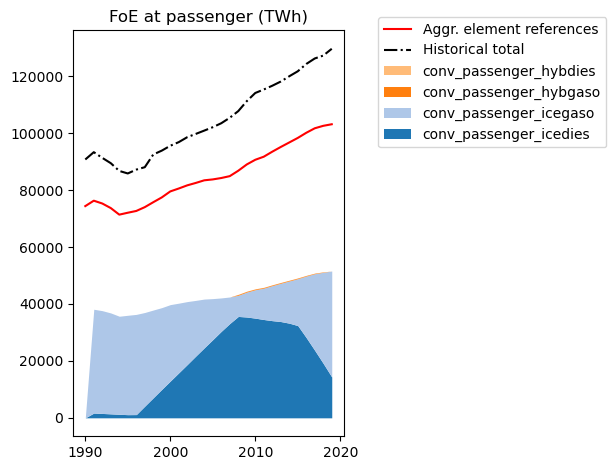

In [58]:
restore_plots.plot_fout_act(model, data_handler, "passenger", unit="TWh")

In [ ]:
restore_plots.plot_fin_act(model, data_handler, "elecsupply")

In [ ]:
# Outflow
restore_plots.plot_fout_ctot(model, data_handler, "elecsupply")

In [ ]:
restore_plots.plot_process_act(model, data_handler, "conv_chp_gas", trd_dir="imp")

In [ ]:
restore_plots.plot_demand(model, "dem_elec")

In [ ]:
restore_plots.plot_emissions_elec_heat(model, data_handler)

In [ ]:
# Outflow
flow = "elecsupply"
element = "conv_chp_coal"
for y in model.Years:
    print(y, 365*sum(model.fout[flow, element, y, h].value for h in model.Hours))

In [ ]:
model.c_export_activity_y0.pprint()